<a href="https://colab.research.google.com/github/SammyGbabs/Skin-Lesion-Model/blob/main/Skin_Lesion_Classifiation_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Introduction**

Skin lesion analysis using machine learning has become increasingly effective due to advancements in computer vision and neural networks. This project aims to develop a classification model to diagnose skin lesions from images, focusing on conditions like measles, chickenpox, monkeypox, and other abnormal skin rashes. By utilizing Convolutional Neural Networks (CNNs), the model will provide an accessible and cost-effective tool for preliminary diagnosis, particularly beneficial in under-resourced areas. The ultimate goal is to improve healthcare accessibility and promote early treatment, reducing the spread of communicable diseases.

Dataset Used: https://www.kaggle.com/datasets/dipuiucse/monkeypoxskinimagedataset

In [1]:
#Importing the necessary libraries
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from keras.regularizers import l1, l2
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

In [3]:
#Getting and loading the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Skin lesion Dataset (1)/Monkeypox Skin Image Dataset (1)",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 770 files belonging to 4 classes.


In [4]:
#Getting the class names
classes = dataset.class_names
classes

['Chickenpox', 'Measles', 'Monkeypox', 'Normal']

In [5]:
#The length of the dataset
len(dataset)

25

In [6]:
#A batch of 32 and each image has size of 256 * 256 pixels
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 256, 256, 3)
[2 3 3 2 3 3 2 2 2 3 3 1 3 3 3 2 0 3 1 2 3 1 0 3 3 3 1 3 2 3 2 2]


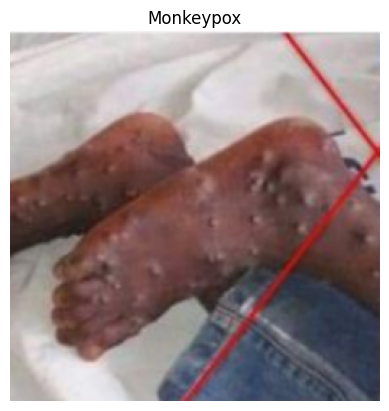

In [7]:
#Viewing one of the images
for image_batch, label_batch in dataset.take(1):
  plt.imshow(image_batch[0].numpy().astype("uint8"))
  plt.title(classes[label_batch[0]])
  plt.axis("off")

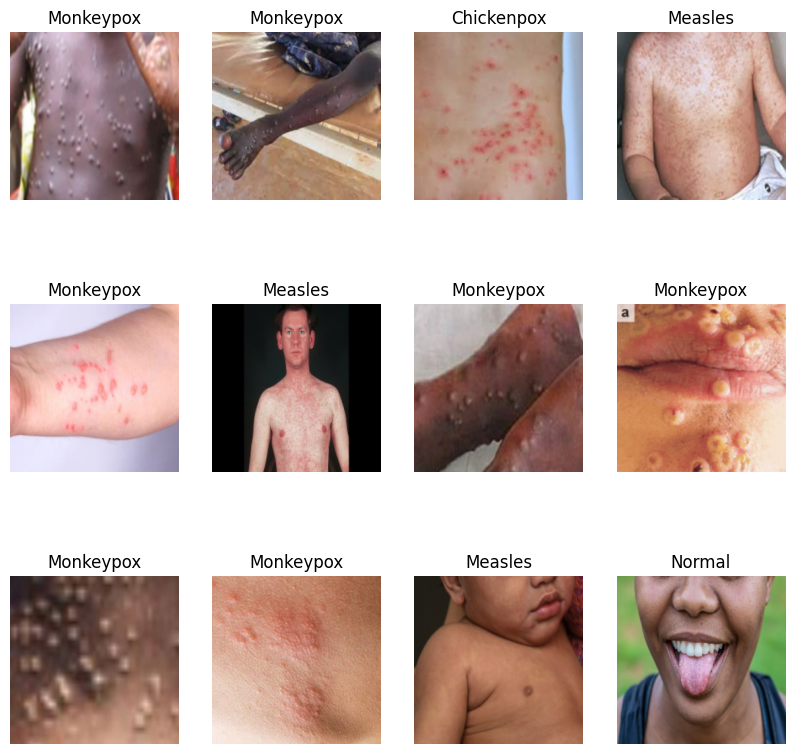

In [10]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(classes[label_batch[i]])
    plt.axis("off")

In [11]:
#Getting the train size for the dataset
train_size = 0.8
len(dataset) * train_size

20.0

In [12]:
#Defining a function to split the dataset in tf
def splitting_dataset_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
  ds_size = len(ds)
  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)
  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)
  return train_ds, val_ds, test_ds

In [13]:
train_ds, val_ds, test_ds = splitting_dataset_tf(dataset)

In [14]:
len(train_ds)

20

In [15]:
len(val_ds)

2

In [16]:
len(test_ds)


3

In [17]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
#Scaling the dataset
scaling = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [19]:
#Using data augmentation for better performance
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

### **TRAINING THE VANILLA MODEL**

In [52]:
input = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
model = models.Sequential([
    scaling,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape = input),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(4, activation='softmax')
])
model.build(input_shape=input)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [53]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [67]:
history = model.fit(
    train_ds,
    epochs = 50,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 92s 5s/step - accuracy: 0.6033 - loss: 0.9858 - val_accuracy: 0.5781 - val_loss: 0.9979
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 88s 4s/step - accuracy: 0.5343 - loss: 1.0339 - val_accuracy: 0.5625 - val_loss: 0.9449
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 90s 4s/step - accuracy: 0.5978 - loss: 0.9673 - val_accuracy: 0.5156 - val_loss: 0.9312
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 91s 5s/step - accuracy: 0.6556 - loss: 0.9236 - val_accuracy: 0.5938 - val_loss: 0.9743
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 139s 4s/step - accuracy: 0.6146 - loss: 0.9752 - val_accuracy: 0.4688 - val_loss: 1.5014
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - accuracy: 0.5520 - loss: 1.1405 - val_accuracy: 0.4531 - val_loss: 1.0248
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 91s 4s/step - accuracy: 0.6471 - loss: 0.9404 - val_accuracy: 0.4219 - val_loss: 1.2688
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 143s 5s/step - accuracy: 0.5611 - loss: 1.0562 - val_accuracy: 0.5469 - val_lo

In [90]:
test_perf = model.evaluate(test_ds)

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.6784 - loss: 0.8978


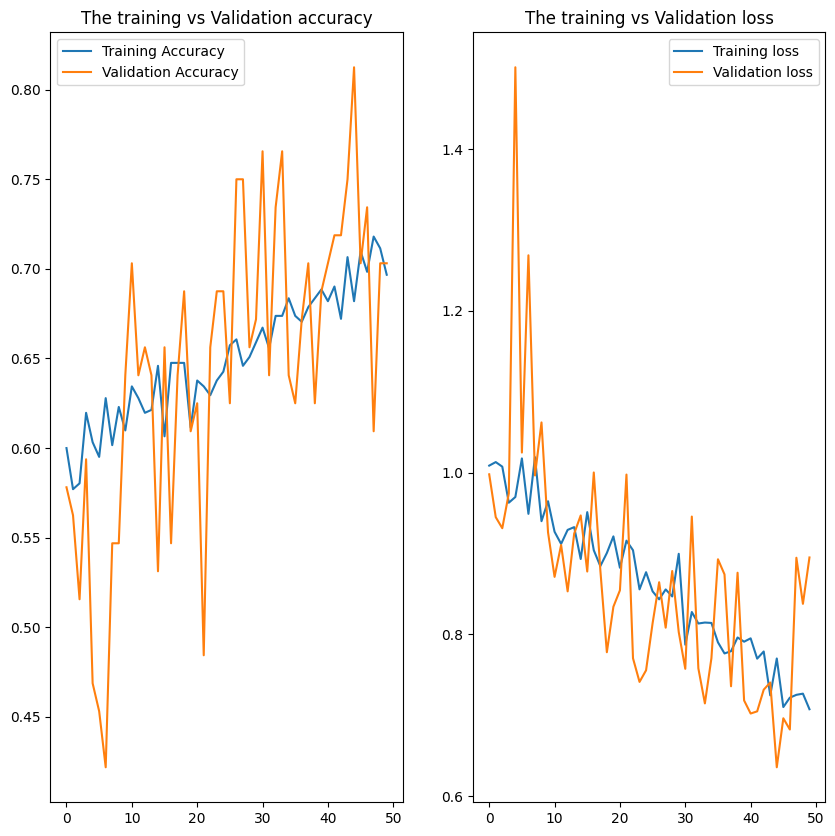

In [91]:
#Doing a plot to visualize the output

accu = history.history['accuracy']
val_accu = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.plot(range(50), accu, label='Training Accuracy')
plt.plot(range(50), val_accu, label='Validation Accuracy')
plt.legend()
plt.title('The training vs Validation accuracy');

plt.subplot(1, 2, 2)
plt.plot(range(50), loss, label='Training loss')
plt.plot(range(50), val_loss, label='Validation loss')
plt.legend()
plt.title('The training vs Validation loss');

First image to predict:
Actual label on dataset: Monkeypox
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted label by model: Monkeypox


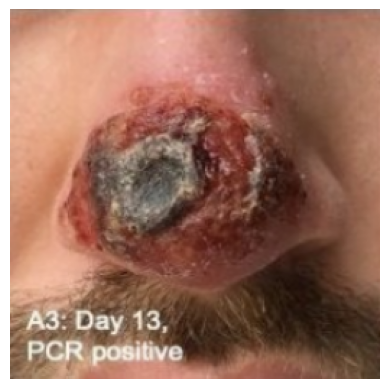

In [93]:
#Making a prediction
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
  img_1 = images_batch[0].numpy().astype('uint8')
  img1_label = labels_batch[0].numpy()

  print('First image to predict:')
  plt.imshow(img_1)
  print('Actual label on dataset:', classes[img1_label])

  batch_prediction = model.predict(images_batch)
  print('Predicted label by model:', classes[np.argmax(batch_prediction[0])])
  plt.axis("off")

In [94]:
#Doing more predictions

def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0)

  predictions = model1.predict(img_array)

  predicted_class = classes[np.argmax(predictions[0])]
  confidence_level = round(100 * (np.max(predictions[0])), 2)
  return predicted_class, confidence_level

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


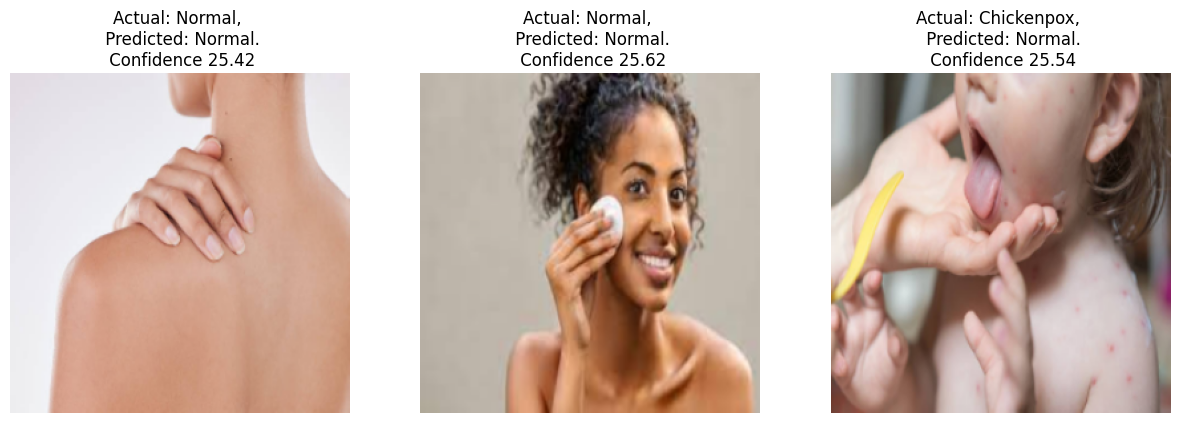

In [103]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
  for i in range(3):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class, confidence_level = predict(model, images[i].numpy())
    actual_class = classes[labels[i]]

    plt.title(f'Actual: {actual_class}, \n Predicted: {predicted_class}.\n Confidence {confidence_level}')
    plt.axis("off")

In [116]:
#Saving the model using Pickle
import pickle

with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

Confusion Matrix:
 [[ 0  0  1 17]
 [ 0  0  0  5]
 [ 1  0  1 35]
 [ 0  0  3 33]]

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00        18
     Class 1       0.00      0.00      0.00         5
     Class 2       0.20      0.03      0.05        37
     Class 3       0.37      0.92      0.52        36

    accuracy                           0.35        96
   macro avg       0.14      0.24      0.14        96
weighted avg       0.21      0.35      0.21        96


Model Performance Metrics:
Accuracy: 0.3542
Precision (Macro): 0.1417
Recall (Macro): 0.2359
F1 Score (Macro): 0.1429


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

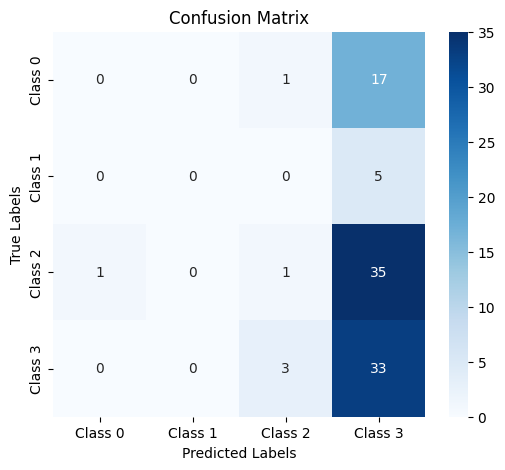

In [111]:
#Error Analysis visualization
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Get true labels and predictions from the test set
y_true = []
y_pred = []

# Iterate over the test set to collect predictions and true labels
for images, labels in test_ds:
    preds = model.predict(images)  # Get predictions
    y_true.extend(labels.numpy())  # True labels: directly use the labels, assuming they're already class indices
    y_pred.extend(np.argmax(preds, axis=1))  # Predicted labels: get predicted class indices from softmax outputs

# Convert lists to numpy arrays for compatibility with metrics
y_true = np.array(y_true).astype(int)  # Ensure y_true is integer type
y_pred = np.array(y_pred)

# Step 2: Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)

# Step 3: Generate a classification report
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1', 'Class 2', 'Class 3']))

# Step 4: Calculate additional metrics: Accuracy, Precision, Recall, F1 Score
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')  # 'macro' for multiclass precision
recall = recall_score(y_true, y_pred, average='macro')  # 'macro' for multiclass recall
f1 = f1_score(y_true, y_pred, average='macro')  # 'macro' for multiclass F1-score

# Print the calculated metrics
print(f"\nModel Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Macro): {precision:.4f}")
print(f"Recall (Macro): {recall:.4f}")
print(f"F1 Score (Macro): {f1:.4f}")

# Step 5: Visualize the confusion matrix as a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'], yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


**TRAINING THE MODEL WITH AT LEAST 3 OPTIMIZATION TECHNIQUE**

In [ ]:
input = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
model1 = models.Sequential([
    scaling,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape = input, kernel_regularizer=l1(0.001)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])
model1.build(input_shape=input)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model1.compile(
    optimizer='RMSprop',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
# Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model1.fit(
    train_ds,
    epochs=20,
    batch_size=32,
    validation_data=val_ds,
    callbacks=[early_stopping]
)

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 95s 5s/step - accuracy: 0.2892 - loss: 1.4274 - val_accuracy: 0.3594 - val_loss: 1.3512
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 89s 4s/step - accuracy: 0.3874 - loss: 1.3592 - val_accuracy: 0.3594 - val_loss: 1.3203
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - accuracy: 0.3635 - loss: 1.3886 - val_accuracy: 0.3594 - val_loss: 1.3046
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - accuracy: 0.3730 - loss: 1.3470 - val_accuracy: 0.3594 - val_loss: 1.3062
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 86s 4s/step - accuracy: 0.3989 - loss: 1.3553 - val_accuracy: 0.3594 - val_loss: 1.2869
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - accuracy: 0.3740 - loss: 1.3170 - val_accuracy: 0.3594 - val_loss: 1.3003
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 91s 4s/step - accuracy: 0.4101 - loss: 1.3149 - val_accuracy: 0.4688 - val_loss: 1.2691
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 85s 4s/step - accuracy: 0.4560 - loss: 1.2838 - val_accuracy: 0.3594 - val_los

In [72]:
test_perf = model1.evaluate(test_ds)

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.7096 - loss: 0.8067


In [115]:
# Saving the model using Pickle
import pickle

with open('model1.pkl', 'wb') as f:
    pickle.dump(model1, f)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Confusion Matrix:
 [[ 2  1 12  3]
 [ 0  1  3  1]
 [ 0  1 35  1]
 [ 0  3  6 27]]

Classification Report:
               precision    recall  f1-score   support

     Class 0       1.00      0.11      0.20        18
     Class 1       0.17      0.20      0.18         5
     Class 2       0.62      0.95      0.75        37
     Class 3       0.84      0.75      0.79        36

    accuracy                           0.68        96
   macro avg       0.66      0.50      0.48        96
weighted avg       0.75      0.68      0.63        96


Model Performance Metrics:
Accuracy: 0.6771
Precision (Macro): 0.6589
Recall (Macro): 0.5018
F1 Score (Macro): 0.4822


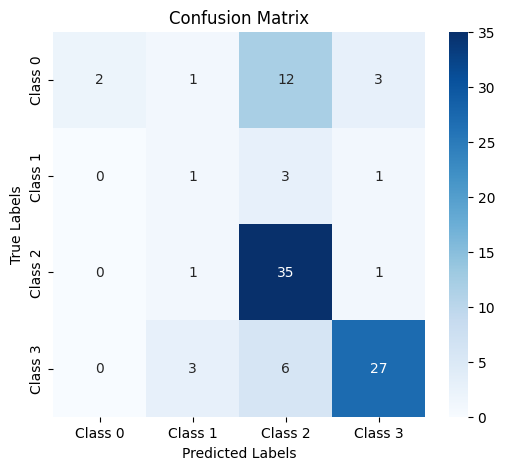

In [112]:
#Error Analysis visualization
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Get true labels and predictions from the test set
y_true = []
y_pred = []

# Iterate over the test set to collect predictions and true labels
for images, labels in test_ds:
    preds = model1.predict(images)  # Get predictions
    y_true.extend(labels.numpy())  # True labels: directly use the labels, assuming they're already class indices
    y_pred.extend(np.argmax(preds, axis=1))  # Predicted labels: get predicted class indices from softmax outputs

# Convert lists to numpy arrays for compatibility with metrics
y_true = np.array(y_true).astype(int)  # Ensure y_true is integer type
y_pred = np.array(y_pred)

# Step 2: Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)

# Step 3: Generate a classification report
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1', 'Class 2', 'Class 3']))

# Step 4: Calculate additional metrics: Accuracy, Precision, Recall, F1 Score
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')  # 'macro' for multiclass precision
recall = recall_score(y_true, y_pred, average='macro')  # 'macro' for multiclass recall
f1 = f1_score(y_true, y_pred, average='macro')  # 'macro' for multiclass F1-score

# Print the calculated metrics
print(f"\nModel Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Macro): {precision:.4f}")
print(f"Recall (Macro): {recall:.4f}")
print(f"F1 Score (Macro): {f1:.4f}")

# Step 5: Visualize the confusion matrix as a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'], yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
